# Попытка обучить DСGAN

Обучение DCGAN на датасете CelebaA  
Не хватило времени и мощностей  
На 24 эпохе обучения генерирует изображения ниже  

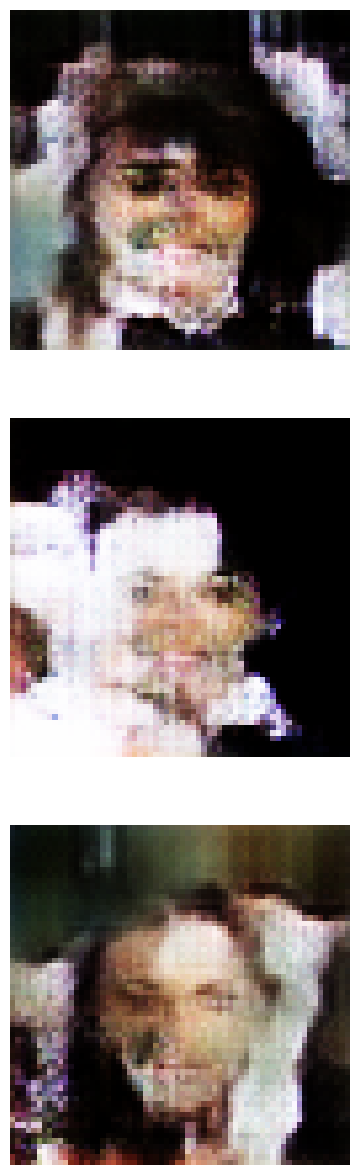

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
filename = './Result/DCGAN/generated_img_epoch-23_'
plt.figure(figsize=(15, 15))
for i in range(3):
    with Image.open(f'{filename}{i}.png') as img:
        img.load()
    plt.subplot(3,1,i+1)
    plt.axis('off')
    plt.imshow(img)

In [1]:
import tensorflow as tf
from keras import Input, Model
from keras.models import Sequential
from keras.utils import image_dataset_from_directory, array_to_img
from keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense
from keras.layers import Reshape, Conv2DTranspose
from keras.optimizers import Adam
from keras.metrics import Mean
from keras.losses import BinaryCrossentropy
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import os


In [2]:
try:
    from google.colab import drive
    from zipfile import ZipFile
    drive.mount('/content/gdrive')
    zip_f =  '/content/gdrive/MyDrive/DataSet/CelebA.zip'
    z = ZipFile(zip_f, 'r')
    z.extractall()
    DATASET_DIR = '/content/CelebA/'
    OUTPUT_DIR = '/content/gdrive/MyDrive/Result/DCGAN/'
    SAVE_DIR = '/content/gdrive/MyDrive/Models/'
except ImportError:
    DATASET_DIR = './Dataset/CelebA/'
    OUTPUT_DIR = './Result/DCGAN/'
    SAVE_DIR = './Models/'

Mounted at /content/gdrive


In [3]:
dataset = image_dataset_from_directory(
    f'{DATASET_DIR}img_align_celeba', label_mode=None, image_size=(64, 64), batch_size=32
).map(lambda x: x / 255.0)

Found 100000 files belonging to 1 classes.


(32, 64, 64, 3)


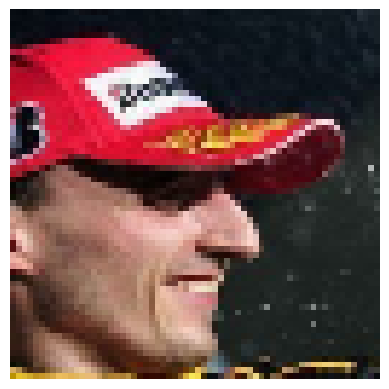

In [4]:
for x in dataset:
    print(x.shape)
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [5]:
discriminator = Sequential(
    [
        Input(shape=(64, 64, 3)),
        Conv2D(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [6]:
latent_dim = 128

generator = Sequential(
    [
        Input(shape=(latent_dim,)),
        Dense(8 * 8 * 128),
        Reshape((8, 8, 128)),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [7]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = Mean(name="d_loss")
        self.g_loss_metric = Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [8]:
class GANMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(f"{OUTPUT_DIR}generated_img_epoch-{epoch}_{i}.png")



In [9]:


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=Adam(learning_rate=0.0001),
    g_optimizer=Adam(learning_rate=0.0001),
    loss_fn=BinaryCrossentropy(),
)

# history = gan.fit(
#     dataset, epochs=epochs, callbacks=[GANMonitor(latent_dim=latent_dim)]
# )

In [10]:
# gan.discriminator.save_weights(f'{SAVE_DIR}GANmodel/discriminator_weight')
# gan.generator.save_weights(f'{SAVE_DIR}GANmodel/generator_weight')
# gan.save_weights(f'{SAVE_DIR}GANmodel/gan_weight')

In [11]:
gan.discriminator.load_weights(f'{SAVE_DIR}GANmodel/discriminator_weight')
gan.generator.load_weights(f'{SAVE_DIR}GANmodel/generator_weight')
gan.load_weights(f'{SAVE_DIR}GANmodel/gan_weight')

In [ ]:
epochs = 20
s_epochs = epochs
epochs +=5
history = gan.fit(
    dataset, initial_epoch=s_epochs, epochs=epochs, callbacks=[GANMonitor(latent_dim=latent_dim)])

Epoch 21/25
3125/3125 [==============================] - 957s 306ms/step - d_loss: 0.6701 - g_loss: 0.9071
Epoch 22/25
3125/3125 [==============================] - 956s 306ms/step - d_loss: 0.6640 - g_loss: 0.9001
Epoch 23/25
3125/3125 [==============================] - 955s 306ms/step - d_loss: 0.6686 - g_loss: 0.9145
Epoch 24/25
3125/3125 [==============================] - 957s 306ms/step - d_loss: 0.6633 - g_loss: 0.9153
Epoch 25/25
1403/3125 [============>.................] - ETA: 8:46 - d_loss: 0.6580 - g_loss: 0.9176

In [1]:
gan.discriminator.save_weights(f'{SAVE_DIR}GANmodel/discriminator_weight')
gan.generator.save_weights(f'{SAVE_DIR}GANmodel/generator_weight')
gan.save_weights(f'{SAVE_DIR}GANmodel/gan_weight')

NameError: ignored